## Step 0: Load The Data

In [23]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import cv2

training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [24]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = max(y_test) - min(y_test) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

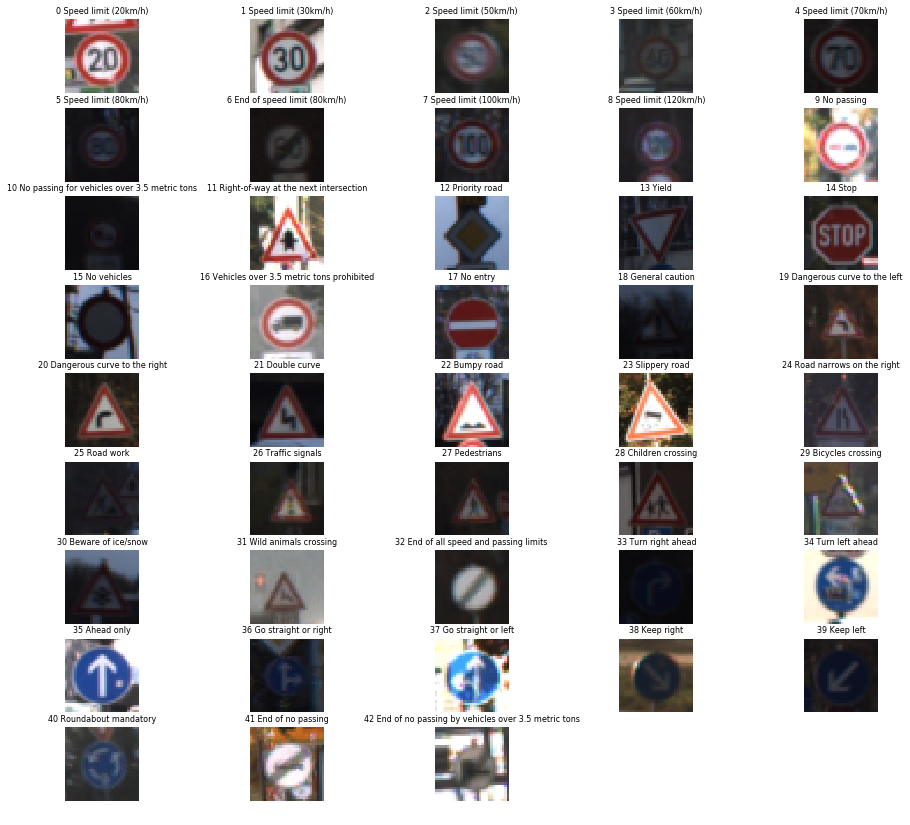

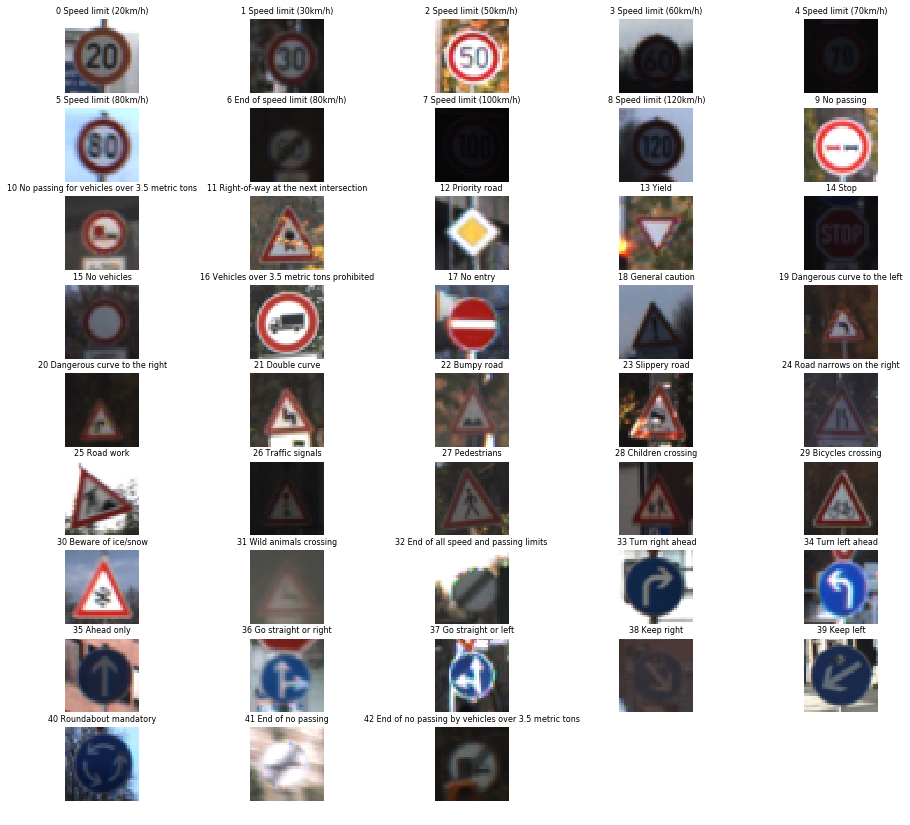

In [26]:
sn = pd.read_csv('signnames.csv')
signnames = list(sn.SignName)

def show_image(location, title, img):
    plt.subplot(*location)
    plt.title(title,fontsize=8)
    plt.axis('off')
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')

plt.figure(figsize=(16,16))
for sign_index in range(n_classes):
    [image_index] = random.sample(list(np.where(y_train == sign_index)[0]),1)
    show_image((10, 5, sign_index+1), str(sign_index) + " " + signnames[sign_index], X_train[image_index])
plt.show()
plt.close()

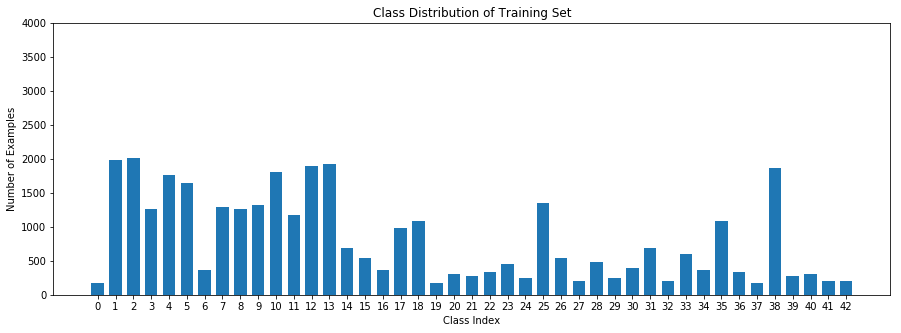

In [27]:
classes = range(n_classes)
counts = []
for sign_code in range(n_classes):
    image_list = list(np.where(y_train == sign_code)[0])
    counts += [len(image_list)]
plt.figure(figsize=(15,5)) 
plt.bar(classes, counts, width=0.7, align='center')
plt.ylabel('Number of Examples')
plt.xlabel('Class Index')
plt.xticks(np.arange(0, 43, 1.0))
plt.title("Class Distribution of Training Set")
plt.ylim([0,4000])
plt.show()

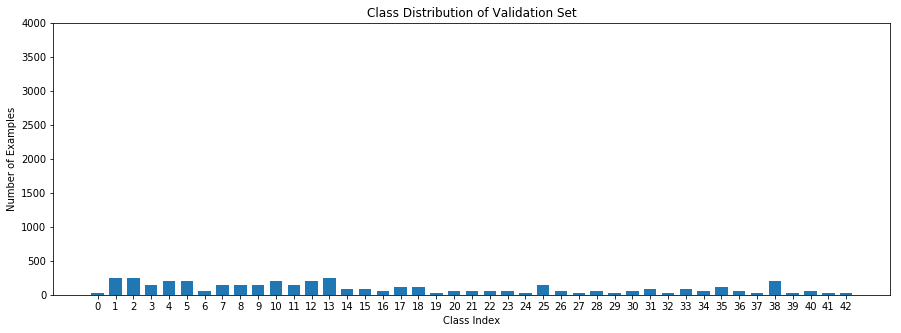

In [28]:
classes = range(n_classes)
counts = []
for sign_code in range(n_classes):
    image_list = list(np.where(y_valid == sign_code)[0])
    counts += [len(image_list)]
plt.figure(figsize=(15,5)) 
plt.bar(classes, counts, width=0.7, align='center')
plt.ylabel('Number of Examples')
plt.xlabel('Class Index')
plt.xticks(np.arange(0, 43, 1.0))
plt.title("Class Distribution of Validation Set")
plt.ylim([0,4000])
plt.show()

## Step 2: Model Architecture

### Dataset Pre-Processing

In [29]:
def preprocessing(X_train):
    # image preprocessing
    # grayscaling
    X_train_gray = X_train[:, :, :, 0]
    for i in range(X_train.shape[0]):
        X_train_gray[i, :, :] = cv2.cvtColor(X_train[i, :, :, :], cv2.COLOR_RGB2GRAY)
    # contrast limited adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    X_train_preproc = X_train_gray
    for i in range(X_train.shape[0]):
        X_train_preproc[i, :, :] = clahe.apply(X_train_preproc[i, :, :])
    # normalize image intensities
    X_train_preproc = 2.0*(X_train_preproc / 255) - 1.0  # normalize intensity
    return X_train_preproc.reshape((X_train_preproc.shape[0], 32, 32, 1))


def augment(X, y, n_classes):
    def rnd_blur(image):
        kernel = random.randint(0,5)
        if kernel == 0 or kernel == 2:
            return image
        if kernel == 1:
            return cv2.GaussianBlur(image, (1, 1), 0)
        if kernel == 3:
            return cv2.GaussianBlur(image, (3, 3), 0)
        if kernel == 5:
            return cv2.GaussianBlur(image, (5, 5), 0)
        if kernel == 4:
            return cv2.GaussianBlur(image, (7, 7), 0)

    def rnd_brightness(image):
        scale = np.random.rand(1)[0] * 0.4 + 0.8  # random scale betw 0.8 and 1.2
        return image * scale

    def rnd_trans(image):
        x = np.round(np.random.rand(1)[0] * 4 - 2)  # random pixel value between -2 and 2
        y = np.round(np.random.rand(1)[0] * 4 - 2)  # random pixel value between -2 and 2
        matrix = np.array([[1, 0, x], [0, 1, y]])
        new_image = cv2.warpAffine(image, matrix, dsize=image.shape)
        # show_image((1, 1, 1), "image", new_image)
        return new_image

    def rnd_rot(image):
        angle = 40 * np.random.rand(1)[0] - 20  # random angle between -20 and 20 degrees
        matrix = cv2.getRotationMatrix2D((16, 16), angle, 1)
        new_image = cv2.warpAffine(image, matrix, dsize=image.shape)
        # show_image((1, 1, 1), "image", new_image)
        return new_image

    def rnd_scale(image):
        scale = np.random.rand(1)[0]*0.4 + 0.8  # random scale betw 0.8 and 1.2
        matrix = cv2.getRotationMatrix2D((16, 16), 0, scale)
        new_image = cv2.warpAffine(image, matrix, dsize=image.shape)
        # show_image((1, 1, 1), "image", new_image)
        return new_image

    def rnd_shear(image):
        cx = 0.5 * np.random.rand(1)[0] - 0.25  # random val betw -0.25 and 0.25
        cy = 0.5 * np.random.rand(1)[0] - 0.25  # random val betw -0.25 and 0.25
        matrix = np.array([[1, cx, 0], [cy, 1, 0]])
        new_image = cv2.warpAffine(image, matrix, dsize=image.shape)
        # show_image((1, 1, 1), "image", new_image)
        return new_image

    X_augmented = X
    y_augmented = y
    for sign_code in range(n_classes + 1):
        image_list = list(np.where(y == sign_code)[0])
        if len(image_list) < 1000:  # augment the classes that have few examples
            print("augmenting class", sign_code, " of ", n_classes)
            for image_index in image_list:
                # add 4 extra randomly perturbed images to dataset
                image = X[image_index, :, :].reshape(32, 32)
                #helpers.show_image((1, 1, 1), "normal", image, 3)
                transformed_image = rnd_scale(rnd_shear(rnd_rot(rnd_trans(rnd_blur(rnd_brightness(image))))))
                #helpers.show_image((1, 1, 1), "transformed", transformed_image, 3)
                transformed_image = transformed_image.reshape(1, 32, 32, 1)
                X_augmented = np.concatenate((X_augmented, transformed_image))
                y_augmented = np.concatenate((y_augmented, np.array([sign_code])))

                transformed_image = rnd_scale(rnd_shear(rnd_rot(rnd_trans(rnd_blur(rnd_brightness(image))))))
                #helpers.show_image((1, 1, 1), "transformed", transformed_image, 3)
                transformed_image = transformed_image.reshape(1, 32, 32, 1)
                X_augmented = np.concatenate((X_augmented, transformed_image))
                y_augmented = np.concatenate((y_augmented, np.array([sign_code])))

                transformed_image = rnd_scale(rnd_shear(rnd_rot(rnd_trans(rnd_blur(rnd_brightness(image))))))
                #helpers.show_image((1, 1, 1), "transformed", transformed_image, 3)
                transformed_image = transformed_image.reshape(1, 32, 32, 1)
                X_augmented = np.concatenate((X_augmented, transformed_image))
                y_augmented = np.concatenate((y_augmented, np.array([sign_code])))

                transformed_image = rnd_scale(rnd_shear(rnd_rot(rnd_trans(rnd_blur(rnd_brightness(image))))))
                # helpers.show_image((1, 1, 1), "transformed", transformed_image, 3)
                transformed_image = transformed_image.reshape(1, 32, 32, 1)
                X_augmented = np.concatenate((X_augmented, transformed_image))
                y_augmented = np.concatenate((y_augmented, np.array([sign_code])))
        else:
            for image_index in image_list:
                # add 1 extra randomly perturbed images to dataset
                image = X[image_index, :, :].reshape(32, 32)
                transformed_image = rnd_scale(rnd_shear(rnd_rot(rnd_trans(rnd_blur(rnd_brightness(image)))))).reshape(1, 32, 32, 1)
                X_augmented = np.concatenate((X_augmented, transformed_image))
                y_augmented = np.concatenate((y_augmented, np.array([sign_code])))
    return X_augmented, y_augmented

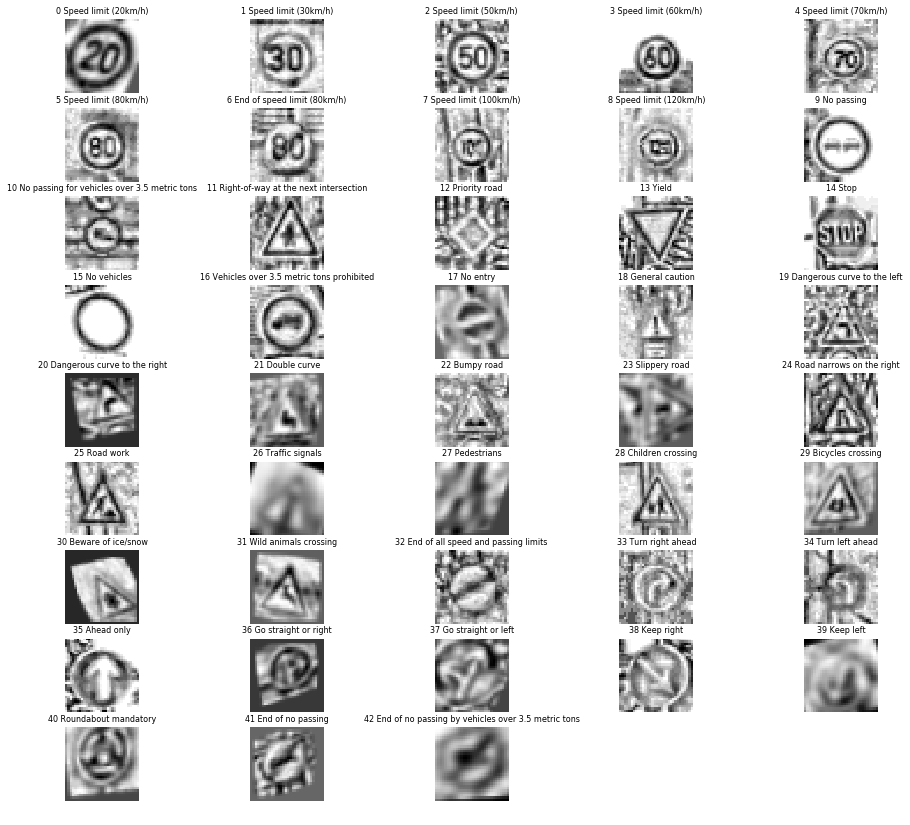

In [32]:
training_file = 'traffic-signs-data/train_preproc_clahe_data.p'  # load preprocessed & preaugmented data from disk
validation_file = 'traffic-signs-data/valid_preproc_clahe_data.p'  # load preprocessed & preaugmented data from disk
testing_file = 'traffic-signs-data/test_preproc_clahe_data.p'  # load preprocessed & preaugmented data from disk

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

plt.figure(figsize=(16,16))

for sign_index in range(n_classes):
    [image_index] = random.sample(list(np.where(y_train == sign_index)[0]),1)
    show_image((10, 5, sign_index+1), str(sign_index) + " " + signnames[sign_index], X_train[image_index].reshape(32,32))
plt.show()
plt.close()

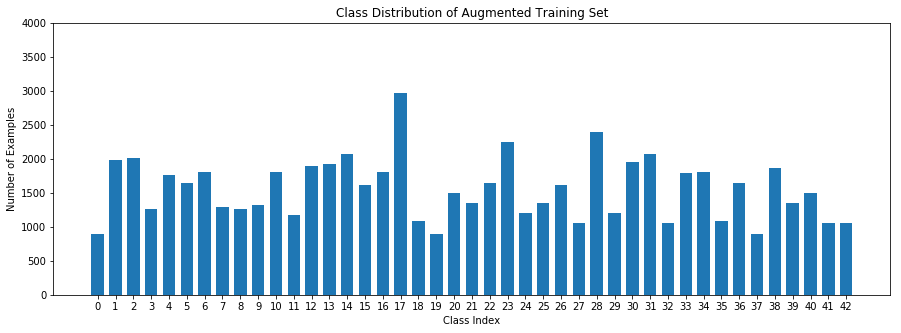

In [33]:
classes = range(n_classes)
counts = []
for sign_code in range(n_classes):
    image_list = list(np.where(y_train == sign_code)[0])
    counts += [len(image_list)]
plt.figure(figsize=(15,5)) 
plt.bar(classes, counts, width=0.7, align='center')
plt.ylabel('Number of Examples')
plt.xlabel('Class Index')
plt.xticks(np.arange(0, 43, 1.0))
plt.title("Class Distribution of Augmented Training Set")
plt.ylim([0,4000])
plt.show()

### Multi-Scale CNN Architecture

In [34]:
def MultiScaleCNNArchV2(x, dropout):
    """
    See "Traffic Sign Recognition with MultiScale Convolutional Neural Networks" by Sermanet, 2011.
    See also https://chatbotslife.com/german-sign-classification-using-deep-learning-neural-networks-98-8-solution-d05656bf51ad.
    I re-implemented an architecture similar to the ones described by Yadav and Sermanet. 
    """
    mu = 0
    sigma = 0.05

    # Layer 1: Convolutional. Input = 32x32x1. Output = 32x32x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    layer1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b
    layer1 = tf.nn.relu(layer1)  # activation
    # Layer 2: Convolutional. Input = 32x32x32. Output = 32x32x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 32), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    layer2 = tf.nn.conv2d(layer1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    layer2 = tf.nn.relu(layer2)  # activation
    # Layer 3: Max Pooling. Input = 32x32x32. Output = 16x16x32.
    layer3 = tf.nn.max_pool(layer2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # Layer 4: Dropout: Input = 16x16x32. Output = 16x16x32.
    layer4 = tf.nn.dropout(layer3, dropout)


    # Layer 5: Convolutional. Input = 16x16x32. Output = 16x16x64.
    conv5_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean=mu, stddev=sigma))
    conv5_b = tf.Variable(tf.zeros(64))
    layer5 = tf.nn.conv2d(layer4, conv5_W, strides=[1, 1, 1, 1], padding='SAME') + conv5_b
    layer5 = tf.nn.relu(layer5)
    # Layer 6: Convolutional. Input = 16x16x64. Output = 16x16x64.
    conv6_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 64, 64), mean=mu, stddev=sigma))
    conv6_b = tf.Variable(tf.zeros(64))
    layer6 = tf.nn.conv2d(layer5, conv6_W, strides=[1, 1, 1, 1], padding='SAME') + conv6_b
    layer6 = tf.nn.relu(layer6)
    # Layer 7: Max Pooling. Input = 16x16x64. Output = 8x8x64.
    layer7 = tf.nn.max_pool(layer6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # Layer 8: Dropout. Input = 8x8x64. Output = 8x8x64.
    layer8 = tf.nn.dropout(layer7, dropout)

    # Layer 9: Convolutional. Input = 8x8x64. Output = 8x8x128.
    conv9_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 64, 128), mean=mu, stddev=sigma))
    conv9_b = tf.Variable(tf.zeros(128))
    layer9 = tf.nn.conv2d(layer8, conv9_W, strides=[1, 1, 1, 1], padding='SAME') + conv9_b
    layer9 = tf.nn.relu(layer9)
    # Layer 10: Convolutional. Input = 8x8x128. Output = 8x8x128.
    conv10_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 128, 128), mean=mu, stddev=sigma))
    conv10_b = tf.Variable(tf.zeros(128))
    layer10 = tf.nn.conv2d(layer9, conv10_W, strides=[1, 1, 1, 1], padding='SAME') + conv10_b
    layer10 = tf.nn.relu(layer10)
    # Layer 11: Max Pooling: Input = 8x8x128. Output = 4x4x128.
    layer11 = tf.nn.max_pool(layer10, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # Layer 12: Dropout. Input = 4x4x128. Output = 4x4x128.
    layer12 = tf.nn.dropout(layer11, dropout)

    # Layer 13: Combining layers 4, 8, and 12 into one flattened layer.
    # Input = 16x16x32, 8x8x64, 4x4x128. Output = 1x14336
    flat_layer4 = tf.contrib.layers.flatten(layer4)
    flat_layer8 = tf.contrib.layers.flatten(layer8)
    flat_layer12 = tf.contrib.layers.flatten(layer12)
    layer13 = tf.concat([flat_layer4, flat_layer8, flat_layer12], axis=1)
    # Layer 14: Fully Connected. Input = 1x14336. Output = 1x1024
    fc14_W = tf.Variable(tf.truncated_normal(shape=(14336, 1024), mean=mu, stddev=sigma))
    fc14_b = tf.Variable(tf.zeros(1024))
    layer14 = tf.matmul(layer13, fc14_W) + fc14_b
    layer14 = tf.nn.relu(layer14)
    # Layer 15: Dropout
    layer15 = tf.nn.dropout(layer14, dropout)
    # Layer 16: Fully Connected: Input = 1x1024. Output = 1x1024.
    fc16_W = tf.Variable(tf.truncated_normal(shape=(1024, 1024), mean=mu, stddev=sigma))
    fc16_b = tf.Variable(tf.zeros(1024))
    layer16 = tf.matmul(layer15, fc16_W) + fc16_b
    layer16 = tf.nn.relu(layer16)
    # Layer 17: Dropout
    layer17 = tf.nn.dropout(layer16, dropout)
    # Layer 18: Fully Connected: Input = 1x1024. Output = 1x43.  43 is the number of traffic sign classes
    fc18_W = tf.Variable(tf.truncated_normal(shape=(1024, 43), mean=mu, stddev=sigma))
    fc18_b = tf.Variable(tf.zeros(43))
    layer18 = tf.matmul(layer17, fc18_W) + fc18_b

    regularizers = (tf.nn.l2_loss(conv1_W)
                    + tf.nn.l2_loss(conv2_W) + tf.nn.l2_loss(conv5_W)
                    + tf.nn.l2_loss(conv6_W) + tf.nn.l2_loss(conv9_W)
                    + tf.nn.l2_loss(conv10_W) + tf.nn.l2_loss(fc14_W)
                    + tf.nn.l2_loss(fc16_W) + tf.nn.l2_loss(fc18_W))

    return layer18, regularizers

### Train, Validate, and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [35]:
import tensorflow as tf
import sklearn as skl
import architecture
import helpers

# Augmentation and preprocessing takes a very long time because I have not multithreaded it. We just do it once then load from disk:
training_file = 'traffic-signs-data/train_preproc_clahe_data.p' # load preprocessed & preaugmented data from disk
validation_file = 'traffic-signs-data/valid_preproc_clahe_data.p' # load preprocessed & preaugmented data from disk
testing_file = 'traffic-signs-data/test_preproc_clahe_data.p' # load preprocessed & preaugmented data from disk

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Hyperparameters
EPOCHS = 100
BATCH_SIZE = 128
rate = 0.0002
dropout = 0.50

# Set up TensorFlow input and output
x = tf.placeholder(tf.float32, (None, 32, 32, 1))  # floats for normalized data
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)
logits, regularizers = architecture.MultiScaleCNNArchV2(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy) + 1e-5 * regularizers
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)
# model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))

accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# training
max_accuracy = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = X_train.shape[0]
    print("Starting procedure number ", p)
    print("Training with batch size ", BATCH_SIZE)
    print()
    for i in range(EPOCHS):
        X_train, y_train = skl.utils.shuffle(X_train, y_train)
        # process each batch
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, loss = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})  # execute session
        validation_accuracy = helpers.evaluate(X_valid, y_valid, accuracy_operation, BATCH_SIZE, x, y, keep_prob)
        print("EPOCH {} ...".format(i + 1), " validation accuracy = {:.3f}".format(validation_accuracy))
        if validation_accuracy > max_accuracy:  # save only highest accuracy we've achieved so far
            max_accuracy = validation_accuracy
            saver.save(sess, './best_model_save_file')
            print("Highest accuracy seen so far. Model saved.")
        else:
            print("Not highest accuracy seen so far. Model not saved.")
        print()
        

Training with batch size  128

EPOCH 1 ...  validation accuracy = 0.771
Highest accuracy seen so far. Model saved.

EPOCH 2 ...  validation accuracy = 0.883
Highest accuracy seen so far. Model saved.

EPOCH 3 ...  validation accuracy = 0.917
Highest accuracy seen so far. Model saved.

EPOCH 4 ...  validation accuracy = 0.939
Highest accuracy seen so far. Model saved.

EPOCH 5 ...  validation accuracy = 0.943
Highest accuracy seen so far. Model saved.

EPOCH 6 ...  validation accuracy = 0.942
Not highest accuracy seen so far. Model not saved.

EPOCH 7 ...  validation accuracy = 0.954
Highest accuracy seen so far. Model saved.

EPOCH 8 ...  validation accuracy = 0.952
Not highest accuracy seen so far. Model not saved.

EPOCH 9 ...  validation accuracy = 0.962
Highest accuracy seen so far. Model saved.

EPOCH 10 ...  validation accuracy = 0.963
Highest accuracy seen so far. Model saved.

EPOCH 11 ...  validation accuracy = 0.963
Not highest accuracy seen so far. Model not saved.

EPOCH 12

Highest accuracy seen so far. Model saved.

EPOCH 91 ...  validation accuracy = 0.987
Not highest accuracy seen so far. Model not saved.

EPOCH 92 ...  validation accuracy = 0.986
Not highest accuracy seen so far. Model not saved.

EPOCH 93 ...  validation accuracy = 0.985
Not highest accuracy seen so far. Model not saved.

EPOCH 94 ...  validation accuracy = 0.983
Not highest accuracy seen so far. Model not saved.

EPOCH 95 ...  validation accuracy = 0.991
Highest accuracy seen so far. Model saved.

EPOCH 96 ...  validation accuracy = 0.984
Not highest accuracy seen so far. Model not saved.

EPOCH 97 ...  validation accuracy = 0.984
Not highest accuracy seen so far. Model not saved.

EPOCH 98 ...  validation accuracy = 0.985
Not highest accuracy seen so far. Model not saved.

EPOCH 99 ...  validation accuracy = 0.985
Not highest accuracy seen so far. Model not saved.

EPOCH 100 ...  validation accuracy = 0.990
Not highest accuracy seen so far. Model not saved.



##### Model saved at 99.1% validation accuracy.

### Run the test set after we have finalized our model

In [37]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('best_model_save_file.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    test_accuracy = helpers.evaluate(X_test, y_test, accuracy_operation, BATCH_SIZE, x, y, keep_prob)
    print("Test set accuracy = ", test_accuracy)

INFO:tensorflow:Restoring parameters from ./best_model_save_file
Test set accuracy =  0.972129849451


##### Test set accuracy is 97.2%

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

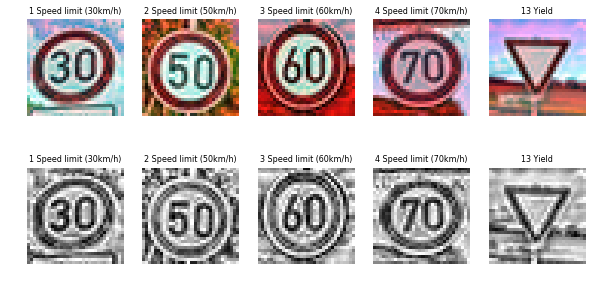

In [41]:
image1 = cv2.cvtColor(cv2.imread('new_images/1.png'), cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(cv2.imread('new_images/2.png'), cv2.COLOR_BGR2RGB)
image3 = cv2.cvtColor(cv2.imread('new_images/3.png'), cv2.COLOR_BGR2RGB)
image4 = cv2.cvtColor(cv2.imread('new_images/4.png'), cv2.COLOR_BGR2RGB)
image5 = cv2.cvtColor(cv2.imread('new_images/13.png'), cv2.COLOR_BGR2RGB)
X_new = np.stack((image1, image2, image3, image4, image5), axis=0)
y_new = [1,2,3,4,13]
X_new_preproc = preprocessing(X_new)

plt.figure(figsize=(10, 5))
for index in range(len(y_new)):
    sign_index = y_new[index]
    show_image((2, 5, index + 1), str(sign_index) + " " + signnames[sign_index], X_new[index].reshape(32,32,3))

for index in range(len(y_new)):
    sign_index = y_new[index]
    show_image((2, 5, 5 + index + 1), str(sign_index) + " " + signnames[sign_index], X_new_preproc[index].reshape(32,32))

plt.show()
plt.close()

### Predicted Sign Type for Each New Image

### Performance Analysis

In [42]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('best_model_save_file.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    new_accuracy = helpers.evaluate(X_new_preproc, y_new, accuracy_operation, 5, x, y, keep_prob)
    print("New set accuracy = ", new_accuracy)

INFO:tensorflow:Restoring parameters from ./best_model_save_file
New set accuracy =  0.600000023842


##### Accuracy on images from outside the dataset: 60.0%

### Top 5 Softmax Probabilities For Each New Image

INFO:tensorflow:Restoring parameters from ./best_model_save_file


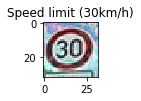

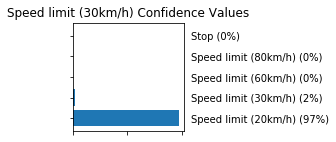

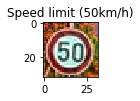

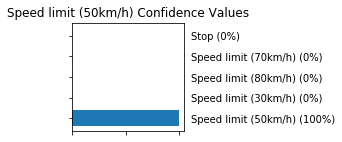

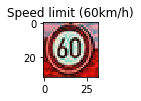

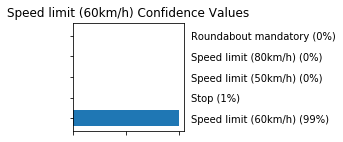

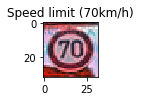

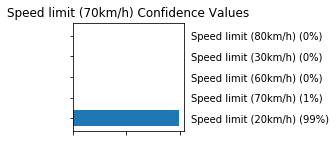

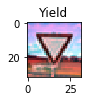

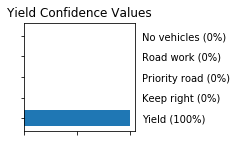

In [44]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('best_model_save_file.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    predictions = sess.run(top_k, feed_dict={x: X_new_preproc, keep_prob: 1.0})

for i in range(5):
    plt.figure(figsize=(1, 1))
    plt.imshow(X_new[i].reshape(32,32,3))
    plt.title(signnames[y_new[i]])
    plt.show()
    plt.figure(figsize=(2, 2))
    probabilities = predictions[0][i]
    sign_numbers = predictions[1][i]
    #plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=2)
    plt.barh(np.arange(5)+.5, probabilities, align='center')
    plt.yticks(np.arange(5)+.5, [(signnames[sign_numbers[i]] + " ({:.0f}%)".format(probabilities[i]*100)) for i in range(len(sign_numbers))])
    plt.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')
    plt.title(signnames[y_new[i]] + " Confidence Values")
    plt.show()